Runs two basic convolutional networks on the pilot dataset.

### Things to do next
- Figure out how to do regression (see below).
- ~~Figure out how to do multitask learning (i.e. try to predict the different reps and different genes).~~
- Run on the scale up dataset.
- Read up on the "Interpreting a DragoNN model using filter visualization" and "Interpreting data with a DragoNN model" in the Dragonn tutorial.

### Installing Dragonn
- Clone from https://github.com/kundajelab/dragonn
- ```python setup.py```
    - I needed to ```brew install geos```

In [1]:
from dragonn import models

from sklearn.model_selection import train_test_split

from collections import OrderedDict
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
import sys

In [3]:
sys.path = ["/opt"] + sys.path

In [4]:
import dragonn

In [5]:
sys.path

['/opt',
 '',
 '/usr/local/anaconda3/envs/dragonn/lib/python27.zip',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/plat-linux2',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/lib-tk',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/lib-old',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/lib-dynload',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/DeepLIFT-0.2-py2.7.egg',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/pydot_ng-1.0.0-py2.7.egg',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/pyprg-0.1.1b7-py2.7.egg',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/sklearn-0.0-py2.7.egg',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/dragonn-0.1.1-py2.7.egg',
 '/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/simdna-0.1-py2.7.egg',
 '/usr/local/anaconda3/envs/dra

Read in the pilot data.
- Samples are sequences that will be one hot encoded
- Try and predict the normalized values. **I couldn't figure out how to do regression with Dragonn, so I just rounded the values to 0 or 1 based on the median.**

In [6]:
key_to_seq = OrderedDict()

with open("../data/Pilot_counts_sequences/PilotDesign.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        key_to_seq[key] = seq
        
pprint(key_to_seq.items()[:5])

[('high_0_0',
  'CTAGGTGGATACAGGTTTCTTCTGAGGGCCAAAGCCTGGGCCCTATTGCTCTGGTTGCCATGGCTGTTTCTTTTCTCTCCTTTCCTTTGATACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAA'),
 ('high_0_1',
  'AAAGCCTGGGCCCTATTGCTCTGGTTGCCATGGCTGTTTCTTTTCTCTCCTTTCCTTTGATACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAAC'),
 ('high_0_2',
  'TGGCTGTTTCTTTTCTCTCCTTTCCTTTGATACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAACCTTTAACAATGAATACCATTCATTATGTAT'),
 ('high_0_3',
  'TACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAACCTTTAACAATGAATACCATTCATTATGTATTTGCTTAATGATACAAAGGCATTGTTTGCT'),
 ('high_0_4',
  'CACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAACCTTTAACAATGAATACCATTCATTATGTATTTGCTTAATGATACAAAGGCATTGTTTGCTCTATTGCAGGTGATAACAGCAGATCAAAGA')]


In [7]:
key_to_normalized_K562_Rep1 = {}
key_to_normalized_K562_Rep2 = {}

with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep1_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep1[key] = val
                
with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep2_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep2[key] = val

# Check that the sequence and value keys line up.
assert set(key_to_normalized_K562_Rep1.keys()) == set(key_to_seq.keys())
assert set(key_to_normalized_K562_Rep2.keys()) == set(key_to_seq.keys())

In [8]:
# One hot encode DNA sequences the standard way.
def one_hot_encode_seq(seq):
    bases = ['A', 'T', 'C', 'G']
    # Gotta be ready for when we discover a new base.
    result = np.zeros((4, len(seq)))
    
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1
    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, 4, len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
    
    return result

In [9]:
X = seqs_to_encoded_matrix(key_to_seq.values())

In [10]:
# Just round to the median, to make this a classification task for now.
K562_Rep1_median = np.median(key_to_normalized_K562_Rep1.values())
K562_Rep1_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep1[key] > K562_Rep1_median, 
        key_to_seq.keys()
    )
).reshape(-1, 1)

K562_Rep2_median = np.median(key_to_normalized_K562_Rep2.values())
K562_Rep2_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep2[key] > K562_Rep2_median, 
        key_to_seq.keys()
    )
).reshape(-1, 1)

y = np.hstack([K562_Rep1_y, K562_Rep2_y])

In [11]:
train_test_split?

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42
)

Start with the model used in the Dragonn tutorial. Train and plot the train and validation loss.

In [13]:
model = models.SequenceDNN(
    seq_length=X_train.shape[3],
    num_filters=[100, 10],
    conv_width=[10, 10],
    num_tasks=y_train.shape[1]
)

In [14]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Loss: 0.6981	Balanced Accuracy: 51.50%	 auROC: 0.540	 auPRC: 0.522	 auPRG: 0.076
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|0.5%	 Num Positives: 1001	 Num Negatives: 1024
Task 1: Loss: 0.6824	Balanced Accuracy: 55.16%	 auROC: 0.589	 auPRC: 0.570	 auPRG: 0.158
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1005	 Num Negatives: 1020
Valid Task 0: Loss: 0.7182	Balanced Accuracy: 52.51%	 auROC: 0.518	 auPRC: 0.559	 auPRG: -0.003
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 124	 Num Negatives: 101
Task 1: Loss: 0.7088	Balanced Accuracy: 54.40%	 auROC: 0.510	 auPRC: 0.556	 auPRG: -0.018
	Recall at 5%|10%|20% FDR: 1.7%|1.7%|1.7%	 Num Positives: 120	 Num Negatives: 105 *
Epoch 2:
Train Task 0: Loss: 0.6785	Balanced Accuracy: 56.64%	 auROC: 0.601	 auPRC: 0.584	 auPRG: 0.199
	Recall at 5%|10%|20% FDR: 0.5%|0.5%|0.8%	 Num Positives: 1001	 Num Negatives: 1024
Task 1: Loss: 0.6652	Balanced Accuracy: 59.64%	 auR

In [15]:
def print_loss(model):
    train_losses, valid_losses = [np.array([epoch_metrics['Loss'] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    train_losses = train_losses.mean(axis=1)
    valid_losses = valid_losses.mean(axis=1)

    f = plt.figure(figsize=(10, 4))
    ax = f.add_subplot(1, 1, 1)
    
    ax.plot(range(len(train_losses)), train_losses, label='Training',lw=4)
    ax.plot(range(len(train_losses)), valid_losses, label='Validation', lw=4)
    
    min_loss_indx = min(enumerate(valid_losses), key=lambda x: x[1])[0]
    ax.plot([min_loss_indx, min_loss_indx], [0, 1.0], 'k--', label='Early Stop')
    ax.legend(loc="upper right")
    ax.set_ylabel("Loss")
    ax.set_ylim((0.0,1.0))
    ax.set_xlabel("Epoch")
    plt.show()

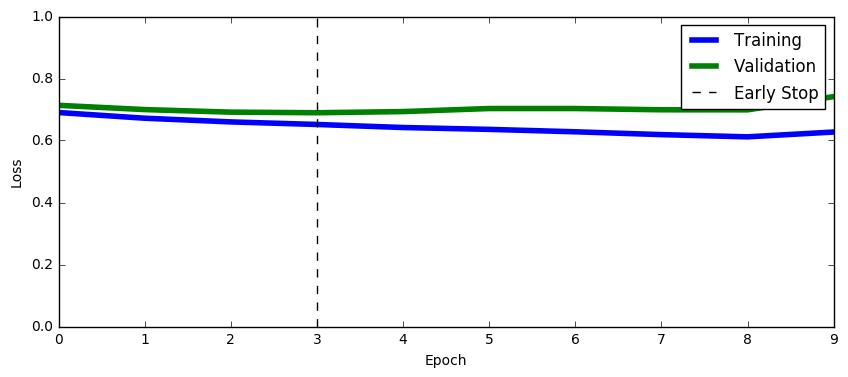

In [16]:
print_loss(model)

Train and test on the multi-filter model used in the tutorial.

In [17]:
multi_filter_model = models.SequenceDNN(
    seq_length=X_train.shape[3],
    num_filters=[15],
    conv_width=[45],
    pool_width=45,
    dropout=0.1,
    num_tasks=y_train.shape[1]
)

In [18]:
multi_filter_model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Loss: 0.7164	Balanced Accuracy: 50.44%	 auROC: 0.512	 auPRC: 0.505	 auPRG: 0.020
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1001	 Num Negatives: 1024
Task 1: Loss: 0.7070	Balanced Accuracy: 53.59%	 auROC: 0.542	 auPRC: 0.522	 auPRG: 0.090
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1005	 Num Negatives: 1020
Valid Task 0: Loss: 0.7456	Balanced Accuracy: 47.96%	 auROC: 0.482	 auPRC: 0.539	 auPRG: -0.018
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|0.8%	 Num Positives: 124	 Num Negatives: 101
Task 1: Loss: 0.7311	Balanced Accuracy: 45.95%	 auROC: 0.468	 auPRC: 0.535	 auPRG: -0.101
	Recall at 5%|10%|20% FDR: 0.8%|0.8%|0.8%	 Num Positives: 120	 Num Negatives: 105 *
Epoch 2:
Train Task 0: Loss: 0.7013	Balanced Accuracy: 52.50%	 auROC: 0.541	 auPRC: 0.532	 auPRG: 0.073
	Recall at 5%|10%|20% FDR: 0.6%|0.6%|0.6%	 Num Positives: 1001	 Num Negatives: 1024
Task 1: Loss: 0.6989	Balanced Accuracy: 55.41%	 auR

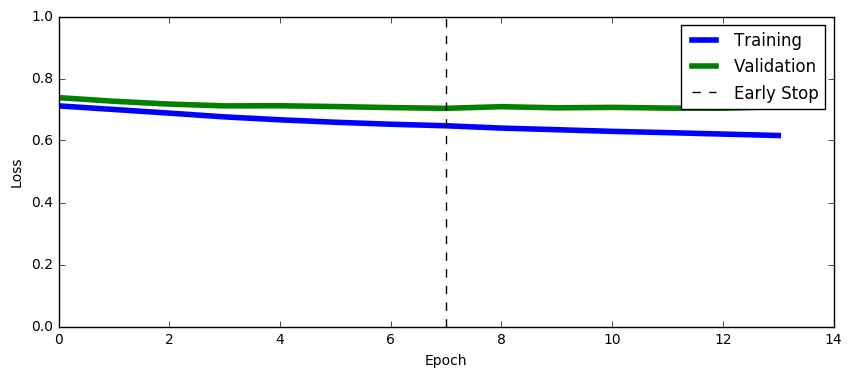

In [19]:
print_loss(multi_filter_model)